In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.session import SparkSession

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc = SparkContext('local')
spark = SparkSession(sc)

df = spark.read.csv('/Users/fanyang/Documents/musicbox/data/event1_downsample.csv', header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [4]:
# convert 'date' from string type into date type
df = df.withColumn('date', F.col('date').cast('date'))
df

DataFrame[uid: string, event: string, song_id: string, date: date]

In [5]:
# count distinct 'uid'
df.select('uid').distinct().count()

59436

In [6]:
# count distinct 'song_id'
df.select('song_id').distinct().count()

464805

In [7]:
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  635296|
|    S|  765613|
|    P|10816337|
+-----+--------+



In [8]:
date_count = df.groupBy('date').count().toPandas()
date_count = date_count.sort_values(by='date')
date_count.set_index('date', inplace=True)
date_count.head(3)

,count
date,
2017-03-30,701756
2017-03-31,715495
2017-04-01,549525


Text(0.5, 0, 'Date')

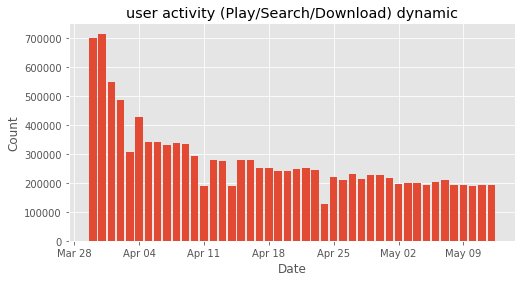

In [9]:
import matplotlib.dates as mdates
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(date_count.index, date_count['count'])
#date_count.plot(kind='bar', ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('user activity (Play/Search/Download) dynamic')
ax.set_ylabel('Count')
ax.set_xlabel('Date')

### 1. label definition: churn is 1, and active is 0

In [10]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:', label_window_start_date, '~', label_window_end_date, 'days:', label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date - datetime.timedelta(feature_window_size - 1)
print('feature window:', feature_window_start_date, '~', feature_window_end_date, 'days:', feature_window_size)


label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


##### select all 'uid' from feature window

In [11]:
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))\
.select('uid').distinct()

In [12]:
df_model_uid.select('uid').distinct().count()

58116

#### select all uid from label window
##### churn is labeled as 1, otherwise active uid is labeled as 0

In [13]:
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) & (F.col('date')<=label_window_end_date))\
.select('uid').distinct().withColumn('Ischurn', F.lit(0))

In [14]:
df_active_uid_in_label_window.select('uid').distinct().count()

23224

In [15]:
df_label = df_model_uid.join(df_active_uid_in_label_window, on=['uid'], how='left')
df_label = df_label.fillna(1)

In [16]:
df_label.groupBy('Ischurn').count().show()

+-------+-----+
|Ischurn|count|
+-------+-----+
|      1|36212|
|      0|21904|
+-------+-----+



In [17]:
import pandas as pd
pd.DataFrame(df_label.take(5), columns=df_label.columns)

,uid,Ischurn
0,126941437,0
1,132952490,0
2,151294213,1
3,163538558,0
4,167328646,1


### 2. generate frequency features (total number of activity in different date frames)

In [18]:
def activity_frequency(data, event, time_window_list, snapshot_date):
    df_feature = data\
    .filter(F.col('event') == event) \
    .groupBy('uid') \
    .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) &
                (F.col('date')<=snapshot_date), 1).otherwise(0)) \
           .alias('freq_' + event +'_last_'+str(time_window)) \
          for time_window in time_window_list])
    return df_feature

In [19]:
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))

In [20]:
event = 'P'
time_window_list = [1,3,7,14,21,30]
snapshot_date = feature_window_end_date
df_play_feature = activity_frequency(df_feature_window, event, time_window_list, snapshot_date)
df_play_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|      uid|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_21|freq_P_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|168551336|            0|            0|            0|             0|             0|            27|
|168555996|            0|            0|            0|             0|             0|            19|
|168580671|           24|          100|          129|           280|           625|          1563|
|168532334|            0|            0|            0|             0|             0|            53|
|168613800|            0|            0|            0|            26|            26|            71|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
only showing top 5 rows



In [21]:
df_play_feature.columns

['uid',
 'freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_21',
 'freq_P_last_30']

In [22]:
df_play_feature1 = df_play_feature.toPandas()
play_features = [
 'freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_21',
 'freq_P_last_30']

Text(0, 0.5, 'counts')

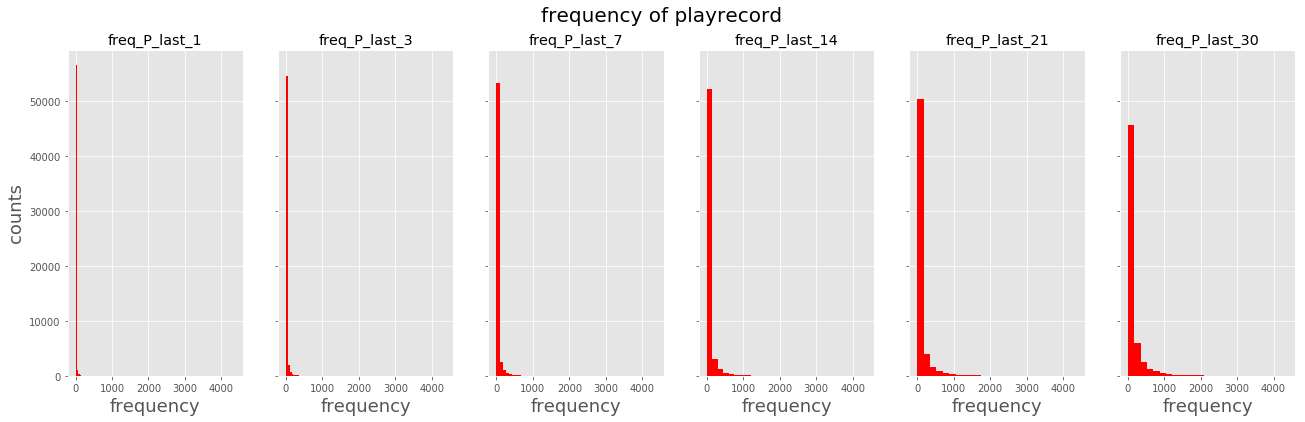

In [23]:
f, axs = plt.subplots(1,6, sharey=True, sharex = True, figsize = (22,6))
f.suptitle('frequency of playrecord', fontsize=20)

for features in play_features:
    i = play_features.index(features)
    df_play_feature1[features].hist(ax = axs[i], bins = 25, color='red')
    axs[i].set_title(features)
    axs[i].set_xlabel('frequency', fontsize=18)
axs[0].set_ylabel('counts', fontsize=18)

In [24]:
event = 'S'
time_window_list = [1,3,7,14,21,30]
snapshot_date = feature_window_end_date
df_search_feature = activity_frequency(df_feature_window, event, time_window_list, snapshot_date)
df_search_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_21|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|168023090|            0|            0|            0|             1|             1|             3|
|167650198|            0|            0|            0|             2|             5|            17|
|167894185|            0|            0|            4|             4|             4|             5|
|167573813|            0|            0|            7|             7|             8|            13|
|167927934|           12|           12|           12|           213|           413|           757|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
only showing top 5 rows



In [25]:
df_search_feature.columns

['uid',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_21',
 'freq_S_last_30']

In [26]:
search_features = [
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_21',
 'freq_S_last_30']

In [27]:
df_search_feature1 = df_search_feature.toPandas()

Text(0, 0.5, 'counts')

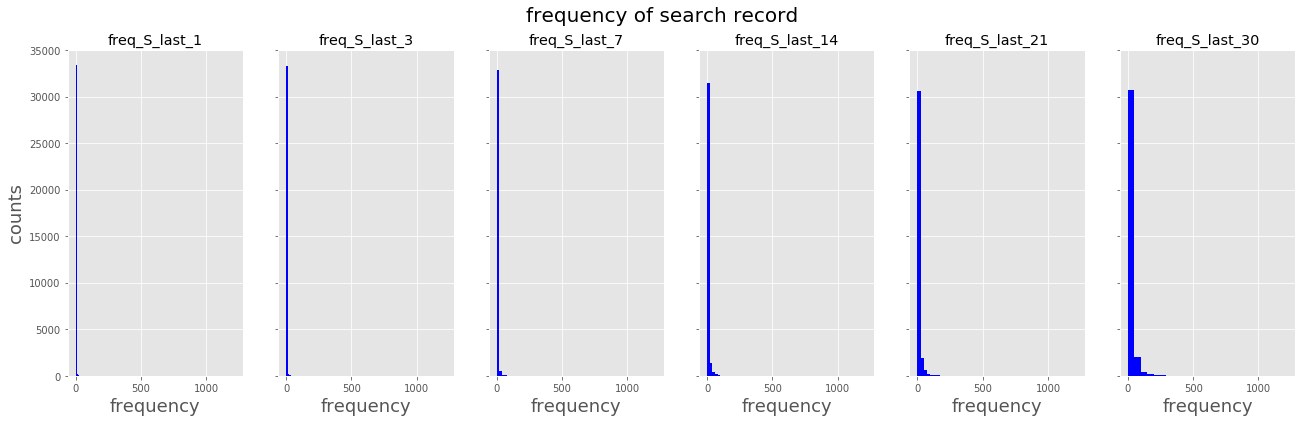

In [28]:
f, axs = plt.subplots(1,6, sharey=True, sharex = True, figsize = (22,6))
f.suptitle('frequency of search record', fontsize=20)

for features in search_features:
    i = search_features.index(features)
    df_search_feature1[features].hist(ax = axs[i], bins = 25, color='blue')
    axs[i].set_title(features)
    axs[i].set_xlabel('frequency', fontsize=18)
axs[0].set_ylabel('counts', fontsize=18)

In [36]:
event = 'D'
time_window_list = [1,3,7,14,21,30]
snapshot_date = feature_window_end_date
df_download_feature = activity_frequency(df_feature_window, event, time_window_list, snapshot_date)
df_download_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|      uid|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_21|freq_D_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
|167759265|            0|            0|            0|             0|             1|             3|
|167927934|            1|            1|            1|            28|            77|           104|
|167769028|            0|            0|            0|             1|             1|             7|
|167926623|            0|            0|            0|             0|             0|             5|
|167941163|            0|            0|            0|             4|             4|             6|
+---------+-------------+-------------+-------------+--------------+--------------+--------------+
only showing top 5 rows



In [37]:
df_download_feature.columns

['uid',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_21',
 'freq_D_last_30']

In [38]:
download_features = [
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_21',
 'freq_D_last_30']

In [39]:
df_download_feature1 = df_download_feature.toPandas()

Text(0, 0.5, 'counts')

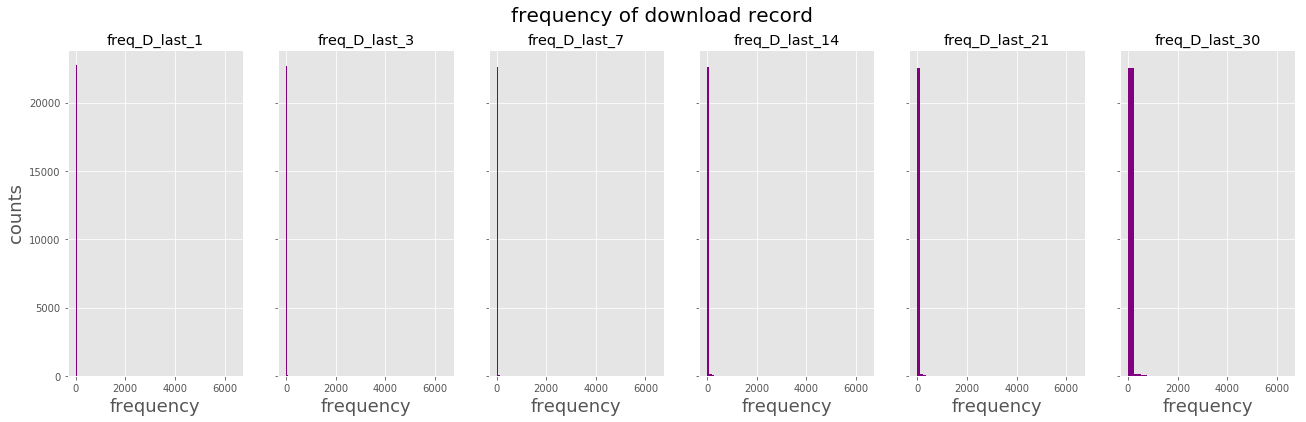

In [40]:
f, axs = plt.subplots(1,6, sharey=True, sharex = True, figsize = (22,6))
f.suptitle('frequency of download record', fontsize=20)

for features in download_features:
    i = download_features.index(features)
    df_download_feature1[features].hist(ax = axs[i], bins = 25, color='purple')
    axs[i].set_title(features)
    axs[i].set_xlabel('frequency', fontsize=18)
axs[0].set_ylabel('counts', fontsize=18)

In [41]:
event_list = ['P', 'D', 'S']
time_window_list = [1,3,7,14,21,30]
df_freq_feature_list = []
for event in event_list:
    df_freq_feature_list.append(activity_frequency(df_feature_window, event, time_window_list, snapshot_date))

In [42]:
df_freq_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_21: bigint, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_21: bigint, freq_D_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_21: bigint, freq_S_last_30: bigint]]

### 3.generate recency features (days since last activity)

In [43]:
def activity_recency(df, event, snapshot_date):
    df_feature = df\
    .filter(F.col('event')==event)\
    .groupBy('uid')\
    .agg(F.datediff(F.lit(snapshot_date), F.max(F.col('date'))).alias('recn_'+ event))
    return df_feature

In [44]:
event = 'P'
snapshot_date = feature_window_end_date
df_feature = activity_recency(df_feature_window,event,snapshot_date)
df_feature.show(5)

+---------+------+
|      uid|recn_P|
+---------+------+
|168551336|    24|
|168555996|    28|
|168580671|     0|
|168532334|    26|
|168613800|     8|
+---------+------+
only showing top 5 rows



Text(0, 0.5, 'count')

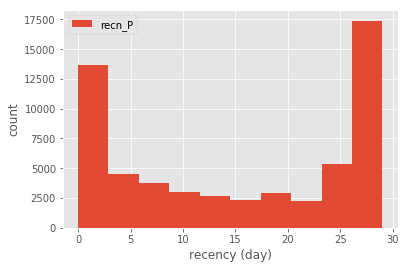

In [69]:
df_feature.toPandas().plot(kind='hist')
plt.xlabel('recency (day)')
plt.ylabel('count')

Text(0, 0.5, 'count')

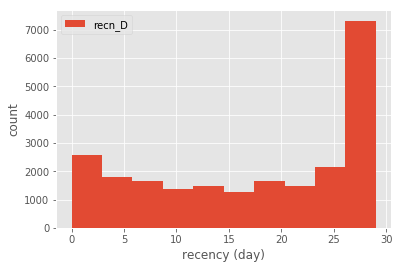

In [70]:
event = 'D'
snapshot_date = feature_window_end_date
df_feature = activity_recency(df_feature_window,event,snapshot_date)
df_feature.toPandas().plot(kind='hist')
plt.xlabel('recency (day)')
plt.ylabel('count')

Text(0, 0.5, 'count')

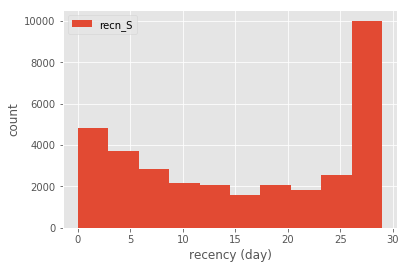

In [72]:
event = 'S'
snapshot_date = feature_window_end_date
df_feature = activity_recency(df_feature_window,event,snapshot_date)
df_feature.toPandas().plot(kind='hist')
plt.xlabel('recency (day)')
plt.ylabel('count')

In [73]:
event_list = ['P', 'D', 'S']
snapshot_date = feature_window_end_date
df_recn_feature_list = []
for event in event_list:
    df_recn_feature_list.append(activity_recency(df_feature_window, event, snapshot_date))

In [74]:
df_recn_feature_list

[DataFrame[uid: string, recn_P: int],
 DataFrame[uid: string, recn_D: int],
 DataFrame[uid: string, recn_S: int]]

### 4. generate additon features based play log (total_play length,  play_percentage on each song, device)

In [75]:
df_play = spark.read.csv('/Users/fanyang/Documents/musicbox/data/play_downsample.csv', header=True).cache()

In [76]:
pd.DataFrame(df_play.take(5), columns=df_play.columns)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag,date
0,168551247,ar,11881432,0,ä¸æ¢¦æµ®ç,é¢æ·¡å¦å¦,78,149,0,2017-03-30
1,168551248,ip,21393368,0,éçï¼Introï¼,å¹¼ç¨å­ææ,87,87,0,2017-03-30
2,168550496,ar,12495422,0,æ¶å¥½ï¼ä½ ä»¬è¦çé«ä¸­æ°å­¦è¯¾,3Då¥å¦å¬è§é¦,369,2747,0,2017-03-30
3,168551179,ar,23485496,0,éå¡æ¶ä»£-(çµå½±ãéå¡ä»»å¡ãçå°¾æ²),åå¾åæ,26,212,0,2017-03-30
4,168548493,ip,6661513,0,å¹²ç©å¥³,å§è,63,243,0,2017-03-30


In [77]:
df_play.select('uid').distinct().count()

59433

In [78]:
# df_play_select_1: select 'uid' that had activity during dates of feature window

df_play_select_1 = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))

In [79]:
df_play_select_1.select('uid').distinct().count()

57954

In [80]:
df_play_select_1['play_time', 'song_length', 'paid_flag'].describe().show()

+-------+------------------+------------------+---------+
|summary|         play_time|       song_length|paid_flag|
+-------+------------------+------------------+---------+
|  count|           8237117|           8239170|  8241922|
|   mean|2605.2293294878123|246.72994247903623|      0.0|
| stddev| 1068882.011072512|371.94926053769467|      0.0|
|    min|      -0.009905762|                -1|        0|
|    max|               nan|               999|        0|
+-------+------------------+------------------+---------+



In [81]:
# df_play_select_2 : select 'uid' that had 'play_time' >0 and 'song_length'> 0

df_play_select_2=df_play_select_1.filter((F.col('play_time')>=0) & (F.col('song_length')>0))

In [82]:
df_play_select_2.select('uid').distinct().count()

55984

In [83]:
# df_play_select3 : select 'uid' that 'play_time' <= 'song_length'

df_play_select_3 = df_play_select_2.filter(F.col('play_time') <= F.col('song_length'))

In [84]:
df_play_select_3.select('uid').distinct().count()

55175

In [85]:
df_play_select_3.createOrReplaceTempView('table1')

In [86]:
df_play_select_3 = spark.sql("SELECT uid, SUM(play_time) AS total_play, SUM(song_length) AS total_song_length \
              FROM table1 \
              GROUP BY uid")

In [87]:
df_play_select_3['total_play', 'total_song_length'].describe().show()

+-------+-----------------+-----------------+
|summary|       total_play|total_song_length|
+-------+-----------------+-----------------+
|  count|            55175|            55175|
|   mean|99543.21029408059|29986.49162806222|
| stddev|1807686.082253844|72415.36005171141|
|    min|              0.0|              2.0|
|    max|     2.59826157E8|        3075217.0|
+-------+-----------------+-----------------+



In [88]:
# approxQuantile(col, probabilities, relativeError)¶
# relativeError – The relative target precision to achieve (>= 0). If set to zero, the exact quantiles are computed, which could be very expensive. Note that values greater than 1 are accepted but give the same result as 1.


# count_ceiling = uid_count.approxQuantile('count', [0.98],0)
# print('98 percentile of user play time is {:0}'.format(count_ceiling[0]))

top_98_quantile_play = df_play_select_3.approxQuantile('total_play', [0.98],0)
top_99_quantile_play = df_play_select_3.approxQuantile('total_play', [0.99],0)

print('0.98 quantile of total play time is:', top_98_quantile_play)
print('0.99 quantile of total play time is:', top_99_quantile_play)

0.98 quantile of total play time is: [259393.0]
0.99 quantile of total play time is: [975716.0]


In [89]:
# we know the feature window is 30 days
# IF we consider unit of play time second

print('0.98 quantile suggest user play music for ', "%.1f"%( top_98_quantile_play[0]/(60*60*30)), ' hours per day' )
print('0.99 quantile suggest user play music for ', "%.1f"%(top_99_quantile_play[0]/(60*60*30)), ' hours per day' )

0.98 quantile suggest user play music for  2.4  hours per day
0.99 quantile suggest user play music for  9.0  hours per day


##### It is possible that uid spent 9 hours on musicbox player.
##### I will remove 'uid' that spend more than 9 hours per day, KEEP 0.99 quantile

In [90]:
top_98_quantile_song = df_play_select_3.approxQuantile('total_song_length', [0.98],0)
top_99_quantile_song = df_play_select_3.approxQuantile('total_song_length', [0.99],0)

print('0.98 quantile of total play time is:', top_98_quantile_song)
print('0.99 quantile of total play time is:', top_99_quantile_song)

0.98 quantile of total play time is: [238829.0]
0.99 quantile of total play time is: [332760.0]


In [91]:
print('0.98 quantile suggest total length of all music for the uid is: ', 
      "%0.1f"%(top_98_quantile_song[0]/(60*60*30)), 'hours per day')
print('0.99 quantile suggest total length of all music for the uid is: ', 
      "%0.1f"%(top_99_quantile_song[0]/(60*60*30)), 'hours per day')

0.98 quantile suggest total length of all music for the uid is:  2.2 hours per day
0.99 quantile suggest total length of all music for the uid is:  3.1 hours per day


###### I think 0.98 and 0.99 quantile of total_song_length look nomral. No need remove

#### The quantile means some users play too much a day, should be removed

In [92]:
# df_play_select_4: select 'uid' that total_play length < 0.99 quantile

df_play_select_4 = df_play_select_3.filter(F.col('total_play') <= top_99_quantile_play[0])

In [93]:
df_play_select_4.select('uid').distinct().count()

54624

In [94]:
# count NA before we go further

df_play_select_4a = df_play_select_4.toPandas().isna().sum()

In [95]:
print('summuary of NA number:\n', df_play_select_4a)

summuary of NA number:
 uid                  0
total_play           0
total_song_length    0
dtype: int64


In [96]:
# generate one new column show percentage of play a song on average 
# new_df = old_df.withColumn('col_n', old_df.col_1 - old_df.col_2)

df_play_select_4 = df_play_select_4.withColumn('play_percentage', df_play_select_4.total_play/df_play_select_4.total_song_length)

In [97]:
df_play_select_4.describe().show()

+-------+--------------------+------------------+------------------+------------------+
|summary|                 uid|        total_play| total_song_length|   play_percentage|
+-------+--------------------+------------------+------------------+------------------+
|  count|               54624|             54624|             54624|             54624|
|   mean|1.6737449265916082E8|20991.262155387678|30041.829664219626| 3.359217196436256|
| stddev|1.0730956346794482E7|57048.310788572075| 71043.28357420773|46.008747649519165|
|    min|           100071797|               0.0|               2.0|               0.0|
|    max|            99581051|          975716.0|         2734161.0| 999.8111888111888|
+-------+--------------------+------------------+------------------+------------------+



In [98]:
df_play_select_4 = df_play_select_4.select('uid', 'total_play', 'play_percentage')

In [99]:
# df_play_select_5: select 'uid' and their 'device' DURING datas of feature window
df_play_device = df_play_select_1.select('uid', 'device').distinct()
df_play_device.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    mc|    2|
|    ar|50626|
|    ip| 7342|
+------+-----+



In [100]:
# combine 'mac' and 'ip' together

df_play_device = df_play_device.withColumn('device', F.when(df_play_device['device'] == 'mc', 0).when(df_play_device['device']=='ip',0).otherwise(1))
df_play_device.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|     1|50626|
|     0| 7344|
+------+-----+



### 5. Combine label and features into one dataframe
##### df_label: 'uid' with churn lable
##### df_freq_feature_list:  uid' with frequency features ----> list
##### df_recn_feature_list: 'uid' with recency feature ---> list
##### df_play_select_4: 'uid' with ('total_play', 'play_percentage') ----> 'uid' had reasonable play record, and function as benchmark
##### df_play_device: 'uid' with device feature


In [101]:
# define function for join

def join_data(df_orig, df_feature_list):
    for df_feature in df_feature_list:
        df_orig = df_orig.join(df_feature, on = 'uid', how='left')
    return df_orig

In [102]:
df_model_1 = join_data(df_play_select_4, df_freq_feature_list)

In [103]:
df_model_2 = join_data(df_model_1, df_recn_feature_list)

In [104]:
df_model_3 = join_data(df_model_2, [df_label])

In [105]:
df_model_4 = join_data(df_model_3, [df_play_device])

In [106]:
df_model_4.fillna(0).toPandas().to_csv('/Users/fanyang/Documents/musicbox/data/churn_model_0116.csv')